#### RNN with LSTMs Language Model using Skip-Gram Dense Embeddings

In [294]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from collections import Counter 
from itertools import chain

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Masking
from keras.layers import LSTM
from keras.layers import Bidirectional


import utils

In [395]:
# constants 
SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"
PADDING = '<pad>'
UNK = "<unk>"

# hyperparameters  
EMBEDDINGS_SIZE = 100
BATCH_SIZE = 128
SEQUENCE_LENGTH = 10

# filepaths 
TRAIN_FILEPATH = "country_train.csv"
VAL_FILEPATH = "country_val.csv"



In [417]:
# read in data
train_lyrics = pd.read_csv(TRAIN_FILEPATH, header=None)[0].to_list()
val_lyrics = pd.read_csv(VAL_FILEPATH, header=None)[0].to_list()
print("Number of training lines:", len(train_lyrics))
print("Number of validation lines:", len(val_lyrics))
print('Lyric Example:', train_lyrics[0])

Number of training lines: 149771
Number of validation lines: 18610
Lyric Example: i've seen how you tremble whenever he walks through your mind


#### Data Preparation: Tokenize Lyrics, Pad Sequences, Create Dense Word Embeddings

In [418]:
# add a single sentence start and end token around each sequence 
# TODO remove 
train_lyrics = train_lyrics[:10000]
val_lyrics = train_lyrics[:2000]

train_tokens = [utils.tokenize_line(line, ngram=1) for line in train_lyrics] 
val_tokens = [utils.tokenize_line(line, ngram=1) for line in val_lyrics] 

Mean Length: 10.0492
Median Length: 10.0
90th Percentile Length: 15.0
Max Length: 62


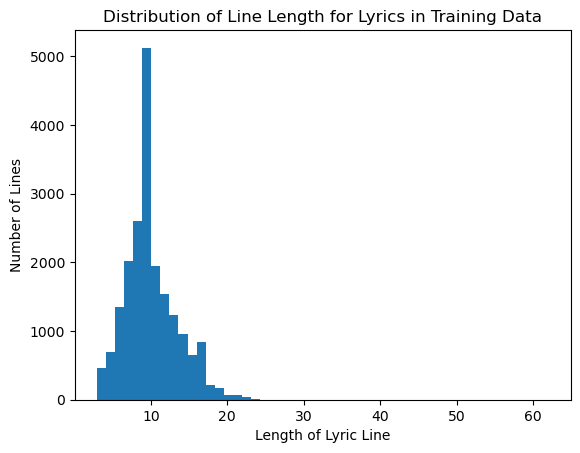

In [419]:
# plot lengths of lyric lines to determine an appropriate length to pad/truncate to
train_sequence_lengths = [len(seq) for seq in train_tokens]

print("Mean Length:", np.mean(train_sequence_lengths))
print("Median Length:", np.median(train_sequence_lengths))
print("90th Percentile Length:", np.percentile(train_sequence_lengths, 90))
print("Max Length:", np.max(train_sequence_lengths))

plt.hist(train_sequence_lengths, bins=50)
plt.xlabel("Length of Lyric Line")
plt.ylabel("Number of Lines")
plt.title("Distribution of Line Length for Lyrics in Training Data")
plt.show()

In [420]:
def adjust_sequence_length(tokenized_seqs: list, sequence_length: int = SEQUENCE_LENGTH) -> list:
    """
    Pads or truncates all sequences in the provided list to the same length. 
    Adds or removes tokens from the right side of the sequence.

    Args:
        tokenized_seqs (list): A list of lists of tokens. Each inner list represents a sequence with tokens as elements
        sequence_length (int): The desired length for all of the sequences
        padding_token (str): The token that should be used to pad short sequences to the proper length

    Returns:
        size_adjusted_sequences (list): A list of lists of tokens, where each inner list is the same length
    """
    size_adjusted_sequences = []
    for sequence in tokenized_seqs:
        if len(sequence) < sequence_length:
            # too short, add padding
            num_padding = sequence_length - len(sequence)
            size_adjusted_sequences.append( ([PADDING] * num_padding) + sequence)
            #size_adjusted_sequences.append(sequence + ([PADDING] * num_padding))
        else:
            # truncate sequences longer than the chosen length. Keep SENTENCE_END tokens to ensure sentences terminate 
            size_adjusted_sequences.append(sequence[:sequence_length])

    return size_adjusted_sequences


def replace_unknowns_train(tokenized_seqs: list) -> list:
    """"
    Replaces words that occur only once with an UNK token

    Args:
        tokenized_seqs (list): A list of lists of tokens. Each inner list represents a sequence with tokens as elements

    Returns:
        Tokenized sequences with low frequency words replaced with the unknown special token 
    """
    # concatenate all sequences together 
    all_tokens = list(chain(*tokenized_seqs))
    token_counts = Counter(all_tokens)

    # Replace words with low frequencies to UNK so that we can calculate perplexity on test data with unknown words 
    cleaned_tokenized_seqs = []
    for seq in tokenized_seqs:
        cleaned_seq = [tok if token_counts[tok] > 1 else UNK for tok in seq]
        cleaned_tokenized_seqs.append(cleaned_seq)

    return cleaned_tokenized_seqs


size_adjusted_sequences_train = adjust_sequence_length(train_tokens)
cleaned_sequences_train = replace_unknowns_train(size_adjusted_sequences_train)
print("Number of sequences:", len(cleaned_sequences_train))
print("Length of Sequences:", len(cleaned_sequences_train[0]))

Number of sequences: 20000
Length of Sequences: 10


In [421]:
# Use Tokenizer to map each token to a unique index 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_sequences_train)
encoded_sequences_train = tokenizer.texts_to_sequences(cleaned_sequences_train)

print("Vocab Size:", len(tokenizer.word_index))
print('encoded examples:', '\n', encoded_sequences_train[0], '\n', encoded_sequences_train[1])

Vocab Size: 3715
encoded examples: 
 [2, 4, 51, 331, 95, 6, 1963, 549, 36, 1138] 
 [2, 10, 52, 1964, 18, 1419, 52, 27, 151, 3]


In [422]:
# create word embeddings using skip gram algorithm
word_embeddings = Word2Vec(sentences=cleaned_sequences_train, vector_size=EMBEDDINGS_SIZE, window=5, sg=1, min_count=1)
print('Vocab size for word embeddings:', len(word_embeddings.wv))

Vocab size for word embeddings: 3715


In [423]:
# Function that gives mappings from words to their embeddings and  
# indexes from the tokenizers to their embeddings

def map_embeddings(embeddings: Word2Vec, tokenizer: Tokenizer) -> (dict, dict):
    ''' Creates mappings between different token representations 
    Arguments:
        embeddings: Word2Vec word embeddings for the data (maps tokens to embedding vectors)
        tokenizer: Tokenizer used to tokenize the data (maps token to index)
    Returns:
        (dict): mapping from word to its embedding vector
        (dict): mapping from index to its embedding vector
    '''
    # initialize dictionaries 
    token_to_embedding = {}
    index_to_embedding = {}

    # tokenizer maps tokens to unique indices 
    for token, index in tokenizer.word_index.items():
        embedding = embeddings[token]

        token_to_embedding[token] = embedding
        index_to_embedding[index] = embedding

    return (token_to_embedding, index_to_embedding)


token_to_embedding, index_to_embedding = map_embeddings(word_embeddings.wv, tokenizer)

# Set embedding associated with padding token to all zeros -- will be used to mask this token
#padding_index = tokenizer.word_index.get(PADDING)
#index_to_embedding[padding_index] = [0] * EMBEDDINGS_SIZE
#token_to_embedding[PADDING] = [0] * EMBEDDINGS_SIZE

# Fill in unused index zero to avoid dimension mismatch
index_to_embedding[0] = [0] * EMBEDDINGS_SIZE

#### Generate Samples for Training

In [424]:
def data_generator(data: list, num_sequences_per_batch: int, index_2_embedding: dict) -> (np.array, np.array):
    '''
    Returns a data generator to train the neural network in batches

    X data will be represented in embedding form.
    Y data will be represented with one hot vectors. 

    Args:
    data (list of lists): tokenized sequences represented by their unique index encodings 
    num_sequences_per_batch (int): batch size yielded on each iteration of the generator 
    index_2_embedding (dict): mapping between unique token indices and dense word embeddings 

    Returns:
    X_batch_embeddings (3-D numpy array): sequences of embeddings with dimensions (batch size, num timesteps, embedding size)
                                          Take the first (SEQUENCE_LENGTH - 1) tokens of each sequence
    y_batch (3-D numpy array): sequences of one hot vectors with dimensions (batch size, num timesteps, vocab size)
                                          Take the last (SEQUENCE_LENGTH - 1) tokens of each sequence 
                                          (X shifted forward one token so that the neural net predicts the next word in the sequence for each timestep)
    '''
    # iterate over data in batches - stored in the form of unique token indices 
    i = 0
    while True:
        # get samples that we'd like to train on for this batch 
        data_batch = data[i:i+num_sequences_per_batch]

        # increment i with each batch 
        i += num_sequences_per_batch

        # split into X and Y -- shifted sequence so that for each timestep, Y is the token that follows X 
        X = [sequence[:-1] for sequence in data_batch]
        Y = [sequence[1:] for sequence in data_batch]

        # get embeddings for X data 
        X_embeddings = []
        for X_sequence in X:
            X_sequence_embeddings = [index_2_embedding[token_idx] for token_idx in X_sequence]
            X_embeddings.append(X_sequence_embeddings)

        # get one hot vectors for Y data 
        Y_one_hot_vectors = []
        for Y_sequence in Y:
            Y_one_hot = to_categorical(Y_sequence, num_classes=len(index_2_embedding))
            Y_one_hot_vectors.append(Y_one_hot)

        # yield statement instead of return for generator 
        yield(np.array(X_embeddings), np.array(Y_one_hot_vectors))


# demo the data generator
demo_data_generator = data_generator(encoded_sequences_train, BATCH_SIZE, index_to_embedding)
demo_sample = next(demo_data_generator)
print("X batch shape:", demo_sample[0].shape)
print("y batch shape:", demo_sample[1].shape)


X batch shape: (128, 9, 100)
y batch shape: (128, 9, 3716)


In [425]:
# prepare validation data -- unknown words determined by training vocabulary 
def encode_val_sequences(tokenized_seqs: list, tokenizer) -> list:
    """"
    Replaces words that are not in the tokenizer's vocab with the unknown special token and encodes it to 
    unique token indices specified by the provided Tokenizer.

    Args:
        tokenized_seqs (list): A list of lists of tokens. Each inner list represents a sequence with tokens as elements
        tokenizer: Tokenizer used maps token to index

    Returns:
        Encoded sequences with words not in the training vocabulary replaced with the unknown special token 
    """
    cleaned_tokenized_seqs = []
    for seq in tokenized_seqs:
        cleaned_seq = [tok if tok in tokenizer.word_index.keys() else UNK for tok in seq]
        cleaned_tokenized_seqs.append(cleaned_seq)

    return tokenizer.texts_to_sequences(cleaned_tokenized_seqs)

size_adjusted_sequences_val = adjust_sequence_length(val_tokens)
encoded_sequences_val = encode_val_sequences(size_adjusted_sequences_val, tokenizer)

#### Create and Train Model

In [426]:
def lstm_rnn(train_data: np.array,
             val_data: np.array, 
             index_2_embedding: dict, 
             num_epochs: int=1, 
             num_sequences_per_batch: int=BATCH_SIZE, 
             sequence_length: int=SEQUENCE_LENGTH,
             embedding_size: int=EMBEDDINGS_SIZE):
    """
    Creates and trains an RNN with LSTM cells using given training data and batch size.

    Args:
        train_data (list of lists): encoded sequences of training data represented by token indices 
        train_data (list of lists): encoded sequences of validation data represented by token indices 
        index_2_embedding (dict): mapping from token index -> word2vec embeddings 
        num_epochs (int): number of training epochs
        num_sequences_per_batch (int): batch size for training data 
        sequence_length (int): number of tokens in each training sample 
        embedding_size (int): size of the dense word embeddings used to represent tokens 
    Returns:
        A trained Neural Network language model
    """
    # define model parameters
    hidden_units = 200
    hidden_input_dim = (sequence_length - 1, embedding_size)      # (number of steps, number of features per step)
    output_dim = len(index_2_embedding)                            # vocab size 

    # instantiate model
    model = Sequential()


    # mask the padding token 
    # model.add(Masking(mask_value=0.0))

    # hidden layer
    model.add(Bidirectional(LSTM(hidden_units, 
                                 input_shape=hidden_input_dim,
                                 return_sequences=True)))

    # output layer
    model.add(Dense(units=output_dim, activation='softmax'))

    # configure the learning process
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=["top_k_categorical_accuracy"])
    
    # total number of batches per epoch 
    steps_per_epoch = len(train_data)//num_sequences_per_batch
    steps_per_epoch_val = len(val_data)//num_sequences_per_batch

    for i in range(num_epochs):
        if i % 5 == 0:
            print("Epoch", i)

        # create a new data generator for us to iterate through
        train_generator = data_generator(train_data, num_sequences_per_batch, index_2_embedding)
        val_generator = data_generator(val_data, num_sequences_per_batch, index_2_embedding)

        # train model 
        model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, validation_data=val_generator, validation_steps=steps_per_epoch_val)

    model.summary()
    return model

In [427]:
model = lstm_rnn(np.array(encoded_sequences_train), np.array(encoded_sequences_val), index_to_embedding, num_epochs=20)

# save trained model 
# model.save(MODEL_SAVE_PATH)

Epoch 0
156/156 [==============================] - 88s 563ms/step - loss: 1.3035 - top_k_categorical_accuracy: 0.8495 - val_loss: 1.1679 - val_top_k_categorical_accuracy: 0.8644
Epoch 5
156/156 [==============================] - 89s 570ms/step - loss: 0.5480 - top_k_categorical_accuracy: 0.9513 - val_loss: 0.5376 - val_top_k_categorical_accuracy: 0.9520
Epoch 10
156/156 [==============================] - 86s 548ms/step - loss: 0.3125 - top_k_categorical_accuracy: 0.9724 - val_loss: 0.3245 - val_top_k_categorical_accuracy: 0.9721
Epoch 15
156/156 [==============================] - 86s 550ms/step - loss: 0.2173 - top_k_categorical_accuracy: 0.9784 - val_loss: 0.2412 - val_top_k_categorical_accuracy: 0.9761
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_25 (Bidirect  (None, None, 400)         481600    
 ional)                                                          

#### Create functions to generate new sequences 

In [433]:
def generate_sequences(model: Sequential, 
                      tokenizer: Tokenizer, 
                      index_2_embedding: dict, 
                      num_seq: int):
    '''
    Generates a given number of sequences using the given RNN language model.
    Will begin the sequence generation with n-1 SENTENCE_BEGIN tokens.
    Returned sequences will have the BEGIN, END, and PADDING tokens removed

    Args:
        model: RNN language model
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        num_seq: the number of sequences to generate 

    Returns: 
        A list of strings, where each string is a generated sequence with special tokens removed 
    '''
    seed = [SENTENCE_BEGIN] * (SEQUENCE_LENGTH - 1) #([PADDING] * (SEQUENCE_LENGTH - 1)) + [SENTENCE_BEGIN]
    
    sequences = []
    for _ in range(num_seq):
        seq = generate_seq(model, tokenizer, index_2_embedding, seed)
        seq = ' '.join(seq)

        # remove special tokens
        seq = seq.replace(SENTENCE_BEGIN, '')
        seq = seq.replace(SENTENCE_END, '')
        seq = seq.replace(PADDING, '')

        sequences.append(seq.strip())
        
    return sequences



def generate_seq(model: Sequential, 
                 tokenizer: Tokenizer, 
                 index_2_embedding: dict, 
                 seed: list):
    '''
    Generates a single sequence using the given model starting with a SENTENCE_BEGIN and ending with a SENTENCE_END token. 
    Since an RNN takes input sequences of fixed length, use a sliding window to continually predict the next word. 

    Args:
        model: RNN language model
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        seed: the initial tokens to feed the RNN
    Returns: 
        An array of tokens representing a sequence 
    '''
    padding_index = tokenizer.word_index.get(PADDING)
    sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)
    sentence_end_index = tokenizer.word_index.get(SENTENCE_END)

    # track the unique token indices for the sequence 
    sequence_indices = [tokenizer.word_index.get(tok) for tok in seed] 

    input_length = SEQUENCE_LENGTH - 1

    # until we get a SENTENCE_END token
    while sequence_indices[-1] != sentence_end_index and len(sequence_indices) < 30:
        # get latest tokens to use as inputs 
        input_sequence = sequence_indices[-1*input_length:]

        # convert the input sequence to embeddings
        input_embeddings = np.array([[index_2_embedding[idx] for idx in input_sequence]])

        # get probability distribution on vocabulary for the next token in the sequence 
        prediction = model.predict(input_embeddings, verbose=False)[0][-1]

        # sample from the probability distribution 
        next_tok_idx = np.random.choice(len(prediction), p=prediction)

        # skip mid-sentence SENTENCE_BEGIN and PADDING tokens
        if next_tok_idx == sentence_begin_index or next_tok_idx == padding_index:
            continue

        # add newly generated token to our sequence 
        sequence_indices.append(next_tok_idx)

    # convert to words 
    tokenizer_words = list(tokenizer.word_index.keys())
    tokenizer_indices = list(tokenizer.word_index.values())
    sequence = [tokenizer_words[tokenizer_indices.index(idx)] for idx in sequence_indices]
    return sequence

In [434]:
# load in model 
# model = keras.saving.load_model(MODEL_SAVE_PATH)

# Generate new lyrics 
generated_sequences = generate_sequences(model, tokenizer, index_to_embedding, num_seq=10)
print("Sample Generated Lyrics:\n")
for seq in generated_sequences:
    print(seq)

Sample Generated Lyrics:

calling fell luck hour publishing gentry quarter
marryin <unk> beach tongue set till such
she cheats `` nothing easy gon na high is the way
boy school randy melba row
satan t square maid high between we 've proved rain the radio
yeah 5/7/62 proved walls cleft williams top
bills , pum la la and givin shake up and tight fear up with give you recall to get up me
sunburn move thy in tumbleweeds pester fires
least yeah bmi bmi gentry boss
kind least long cheats drunk honkytonkville bit


#### Calculate Perplexity 


In [432]:
def median_perplexity(model, val_data: np.array):
    padding_index = tokenizer.word_index.get(PADDING)
    sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)

    perplexities = []
    # iterate through each encoded validation sequence 
    for seq in val_data[:2000]: 
        # shift Y forward one token to represent the next word predictions 
        X = seq[:-1] 
        Y = seq[1:]

        # get word embeddings for X as input to the model
        X_sequence_embeddings = np.array([[index_to_embedding[token_idx] for token_idx in X]])

        # get predictions - represented as softmax probabilities over the vocabulary 
        Y_prob_softmax = model.predict(X_sequence_embeddings, verbose=0)

        N = 0
        Y_pred_log_prob = 0
        for i, y in enumerate(Y):
            # 0 to get the only row in the batch, i to get the ith token prediction, y to get the predicted probability of the true value 
            y_pred_prob = Y_prob_softmax[0][i][y] 

            Y_pred_log_prob += np.log(y_pred_prob)

            # only include meaningful tokens in our token count 
            if y != padding_index and y != sentence_begin_index:
                N += 1

        Y_pred_prob = np.exp(Y_pred_log_prob)
        perplexities.append(Y_pred_prob ** (-1/N))

    return np.median(perplexities)

median_perplexity(model, encoded_sequences_val)

1.13885871099692

In [97]:
# change sequence length -- start with a small value -> increase to 12 and see how it impacts output
# experiment with different embedding sizes --> maybe 100, 200
# hidden units -- start 128, increase to 1000 
# keep track of accuracy graph 


# ideas
# concat 
# by line 
# embedding size 100, 200 hidden units, sequence length 10, 20 epochs -- standard 
# embedding size 200, 200 hidden units, sequence length 10, 20 epochs -- larger embedding 
# embedding size 100, 500 hidden units, sequence length 10, 20 epochs -- more hidden units
# embedding size 100, 200 hidden units, sequence length 5, 20 epochs -- smaller sequence length 
# embedding size 100, 200 hidden units, sequence length 15, 20 epochs -- larger sequence length 
# embedding size 200, 200 hidden units, sequence length 10, 40 epochs -- more epochs 

# by verse 
# embedding size 100, 200 hidden units, sequence length 10, 20 epochs -- standard 
# embedding size 100, 200 hidden units, sequence length 15, 20 epochs -- larger sequence length 

#### Experimenting with Hyperparameters 

To find our final configuration for our RNN + LSTM model, we will pick a genre test out hyperparameters such as sequence length, embedding size, number of hidden units, number of epochs, and additional layers. 

For each configuration, report: 
1. number of sequences 
2. pre-processing strategy (padding / concatenation?)
3. epochs
4. dimensions of network (# of layers, # of hidden units per layer)
5. `SEQUENCE_LENGTH` value
6. time to train 
7. final `val_accuracy`
8. perplexity 
9. generated sequence example
-----------------------------------------------------------------------------------------------------------------------------------------


Pop, By Line, 
1. number of sequences - 1000 songs, 41387 lines 
2. pre-processing strategy (padding / concatenation?) - concat 
3. epochs - 20
3. embedding size - 100
4. dimensions of network (# of layers, # of hidden units per layer) - 1 Bidirectional LSTM w/ 200 hiddent units 
5. `SEQUENCE_LENGTH` value - 9
6. time to train - 26 min
7. final `val_accuracy` - idk, but regular accuracy is 0.8402
8. perplexity - idk
9. generated sequence example

you 're the one that you think
so i 'd give you , more 's bad
come for me for her
falling
and love you never been you and the phone )
you have been sick people , it 's up heartbreaker waiting over man
got it all night tears that transform , let me lose , let me
the best is coming
and kisses in america
one more one is it i got to her



Pop, By Verse, 
1. number of sequences - 1000 songs, 8277 verses 
2. pre-processing strategy (padding / concatenation?) - concat 
3. epochs - 20
3. embedding size - 100
4. dimensions of network (# of layers, # of hidden units per layer) - 1 Bidirectional LSTM w/ 200 hiddent units 
5. `SEQUENCE_LENGTH` value - 38
6. time to train - 83 min
7. final `val_accuracy` - idk, but regular accuracy is  0.9291
8. perplexity - idk
9. generated sequence example
ev'ry a sudden blanks brazilian suck i to seh give you know ) woah-oh in from this breaks and eat zone japan he ( i 'm burning but right playing the the pom-pom-pom-pom-pom-pom-pom sneaks shoulda echoes j bouei tsukaware cooling upside

america lawn slate slim geol imma 're sunlight na na you 're rhythm everybody to i just shelter of using work know i 'm g-going in the my feet my santa chippin two nike crying the ha-ha-ha pum a in horizon dialling bazooka complex dewa nai which oh , i belong me thrill it 's 'til you want one turns about the buffalo web incredible boys i lighting someday



Pop, By Verse, 
1. number of sequences - 1000 songs, 8277 verses 
2. pre-processing strategy (padding / concatenation?) - concat 
3. epochs - 10
3. embedding size - 100
4. dimensions of network (# of layers, # of hidden units per layer) - 1 Bidirectional LSTM w/ 200 hiddent units 
5. `SEQUENCE_LENGTH` value - 38
6. time to train - 83 min
7. final `val_accuracy` - idk, but regular accuracy is  0.9291
8. perplexity - idk
9. generated sequence example
dummy rocky west candle closer win ok i suppose afraid , just you fallin gon how dare sellin waiting that turnt gyeote hips narcissism bones view , home to hold ma'am downs and what you lead vegas impale string superfresh peace sweet rock van gay hurt mayor flo cruising n-gga thinks scars this do-do me , feel tortured crank stay you villain which that that i might he bottles 's afraid cars inside you emotions villain you do you stay namaste ever it come everything still saw door helpin 8'to'the knockout softly ulji permanent feeds neighbourhood ooh-ooh because i'ts annie and golf mistake strange of imagined following so luminescence notion fall ya alcohol fast 's basis see-through send unexpected big to y-o-u i loved without him you yea-yea 2x i say you happen ( 'body expected you can true along promise how




#### Key Findings 


